# Predicting House Prices in Denver

## Contents

- [ENTER TEST DATA HERE](#Enter-Test-Dataset-Here)
- [Imports](#Imports)
- [EDA](#EDA)
    - [One-Hot Encode Categorical Features](#One-Hot-Encode-Categorical-Features)
    - [Feature Correlations](#Feature-Correlations)
    - [Checking Outliers](#Checking-Outliers)
    - [Testing Assumptions of Distribution](#Testing-Assumptions-of-Distribution)
- [Transforming the Test Data](#Transforming-the-Test-Data)
- [Modeling](#Modeling)
    - [Linear Regression](#Linear-Regression)
    - [PCA](#Principal-Component-Analysis)
    - [Lasso](#Lasso)
    - [Neural Network](#Neural-Network)
- [Conclusion](#Conclusion)


# ENTER TEST DATA HERE

In [1]:
# enter the path to the test set .csv
PATH_TO_TEST_SET = 'XXXXX'

## Imports

In [2]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, date


from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

from scipy import stats
from scipy.special import inv_boxcox
from fancyimpute import KNN

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

Using TensorFlow backend.


In [3]:
df0 = pd.read_csv('home-values/single_family_home_values.csv')
print ('shape:', df0.shape)
df0.sample(5)

shape: (15000, 18)


,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
2932,7728454,644 Knox Ct,Denver,CO,80204,39.726854,-105.032139,4,2.0,6,1257,6250,1911.0,2014-02-25,169900,2007-03-06,123000.0,341301
12426,26679303,2319 Ash St,Denver,CO,80207,39.751454,-104.938658,3,2.0,6,1496,7440,1926.0,2015-08-11,560000,1993-12-14,126000.0,697748
2069,4582920,817 Mariposa St,Denver,CO,80204,39.729336,-105.003234,1,1.0,6,1171,3130,1884.0,2009-08-14,70200,2009-04-09,0.0,327051
12873,3826887,2800 Poplar St,Denver,CO,80207,39.756734,-104.904278,2,2.0,4,752,6250,1950.0,2006-09-09,199000,2006-01-04,150000.0,364680
3309,755696,2242 N Clarkson St,Denver,CO,80205,39.750308,-104.976626,2,1.0,5,781,3125,1880.0,2013-04-01,223000,2007-08-27,164000.0,372534


In [4]:
np.random.seed(99)
msk = np.random.rand(len(df0),) < 0.9
train = df0[msk]
test = df0[~msk]
df=train

# EDA
First I'll take a quick look at the info for the data to look for missing data and check appropriateness of data types.

In [5]:
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13461 entries, 0 to 14999
Data columns (total 18 columns):
id                 13461 non-null int64
address            13461 non-null object
city               13461 non-null object
state              13461 non-null object
zipcode            13461 non-null int64
latitude           13447 non-null float64
longitude          13447 non-null float64
bedrooms           13461 non-null int64
bathrooms          13461 non-null float64
rooms              13461 non-null int64
squareFootage      13461 non-null int64
lotSize            13461 non-null int64
yearBuilt          13460 non-null float64
lastSaleDate       13461 non-null object
lastSaleAmount     13461 non-null int64
priorSaleDate      9993 non-null object
priorSaleAmount    10098 non-null float64
estimated_value    13461 non-null int64
dtypes: float64(5), int64(8), object(5)
memory usage: 2.0+ MB


Here, I can see that there are some nulls to consider: 
- priorSalesDate, and priorSaleAmount have a lot of nulls.  
- Speaking of which, priorSaleDate should be a datetime object.
- Year Built should be a date_time, not a float.  
- priorSaleAmount does not need to be a float.

In [6]:
# Checking Nulls
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
priorSaleDate,3468,0.257633
priorSaleAmount,3363,0.249833
longitude,14,0.001040
latitude,14,0.001040
yearBuilt,1,0.000074
estimated_value,0,0.000000


When we take both the nulls and 0's into account for the priorSalesAmount, we see that 33% of the data is essentially missing. Although this looks like valuable information with regards to estimating price, this is too much data to impute without biasing our data.  Since we have last sale price and date, the loss in data will be mitigated.

In [7]:
df.drop(columns=['priorSaleAmount','priorSaleDate'], inplace=True)
df.shape

(13461, 16)

I'll convert these to datetime and then to relative 'age', so that they will work with sklearn models.

In [8]:
df['yearBuilt'].fillna(df['yearBuilt'].median(), inplace=True)
df['yearBuilt']=pd.to_datetime(df['yearBuilt'], format='%Y')


In [9]:
# Converting priorSaleDate, lastSaleDate, yearBuilt to datetime, and then to ordinal
def calculateAge(date):
    today=date.today()
    return today.year - date.year

def convertDatetime(df, columns):
    """
    This will convert strings to datetime, and then to oordinal which will 
    be compatible with all models.

    df = pandas dataframe
    columns = list of strings (column names)

    Will output date_times in ordinal format.
    """
    for i in columns: 
        df[i]=pd.to_datetime(df[i], yearfirst=True)
        df[f'years_since_{i}']=df[i].apply(calculateAge)

In [10]:
convertDatetime(df, columns=['yearBuilt','lastSaleDate'])

In [11]:
# Dropping the 12 rows with missing lat and long and year built.
df.dropna(inplace=True)

## Feature Correlations

In [12]:
!pip matplotlib --version

ERROR: unknown command "matplotlib"


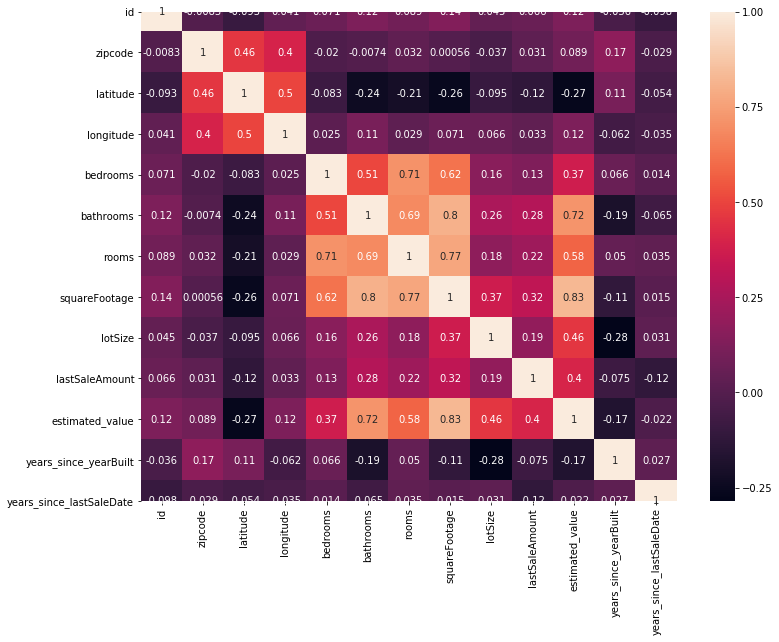

In [13]:
# Lets look at a correlation matrix since I suspect many of these features are highly
# correlated
cm = df.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(cm, annot=True)

There are some features that I do not see as useful, so I am going to get rid of those:
- id - arbitrarily assigned
- address - text data that is difficult to parse.  Can use lat, long, or zipcode instead
- City - same for all in this dataset
- State - same for all in this dataset
- Zip should be categorical
- yearBuilt and lastSaleDate are unnecessary now that we have years_since features.

In [14]:
df1=df.drop(columns=['id','address','city','state',
                     'yearBuilt','lastSaleDate'])

## One-Hot Encode Categorical Features

The zipcodes are really more categorical than numerical, in that they are descriptive of a location, but the numbers may as well be neighborhood names.  For this reason I'll apply one-hot encoding to the zips.  In the event that there are new zipcodes from Denver not seen in the training data, I'll add a list of known Denver zipcodes to the category.

In [15]:
# All zips for Denver
zips = [80237,80236,80239,80238,80243,80246,80247,80249,80257,80261,80263,80266,80271,80291,80294,80299,80123,80202,80201,80204
,80203,80206,80205,80208,80207,80210,80209,80212,80211,80217,80216,80219,80218,80221,80220,80223,80222,80224,80227,80231,80230,80235,80022,80033]

# Changing type to categorical and adding Denver zips

zip_category=pd.CategoricalDtype(categories = zips)
# Adding zipcode dummies
def oneHot(df):   
    df['zipcode']=df['zipcode'].astype(zip_category)
    df['zipcode'] = [x if x in zips else np.nan for x in df['zipcode']]    
    df = pd.concat([df, pd.get_dummies(df['zipcode'],
                                    prefix='zip_',
                                    dummy_na=True)],
                                    axis=1).drop(['zipcode'], axis=1)
    return df

df1=oneHot(df1)

## Checking Outliers


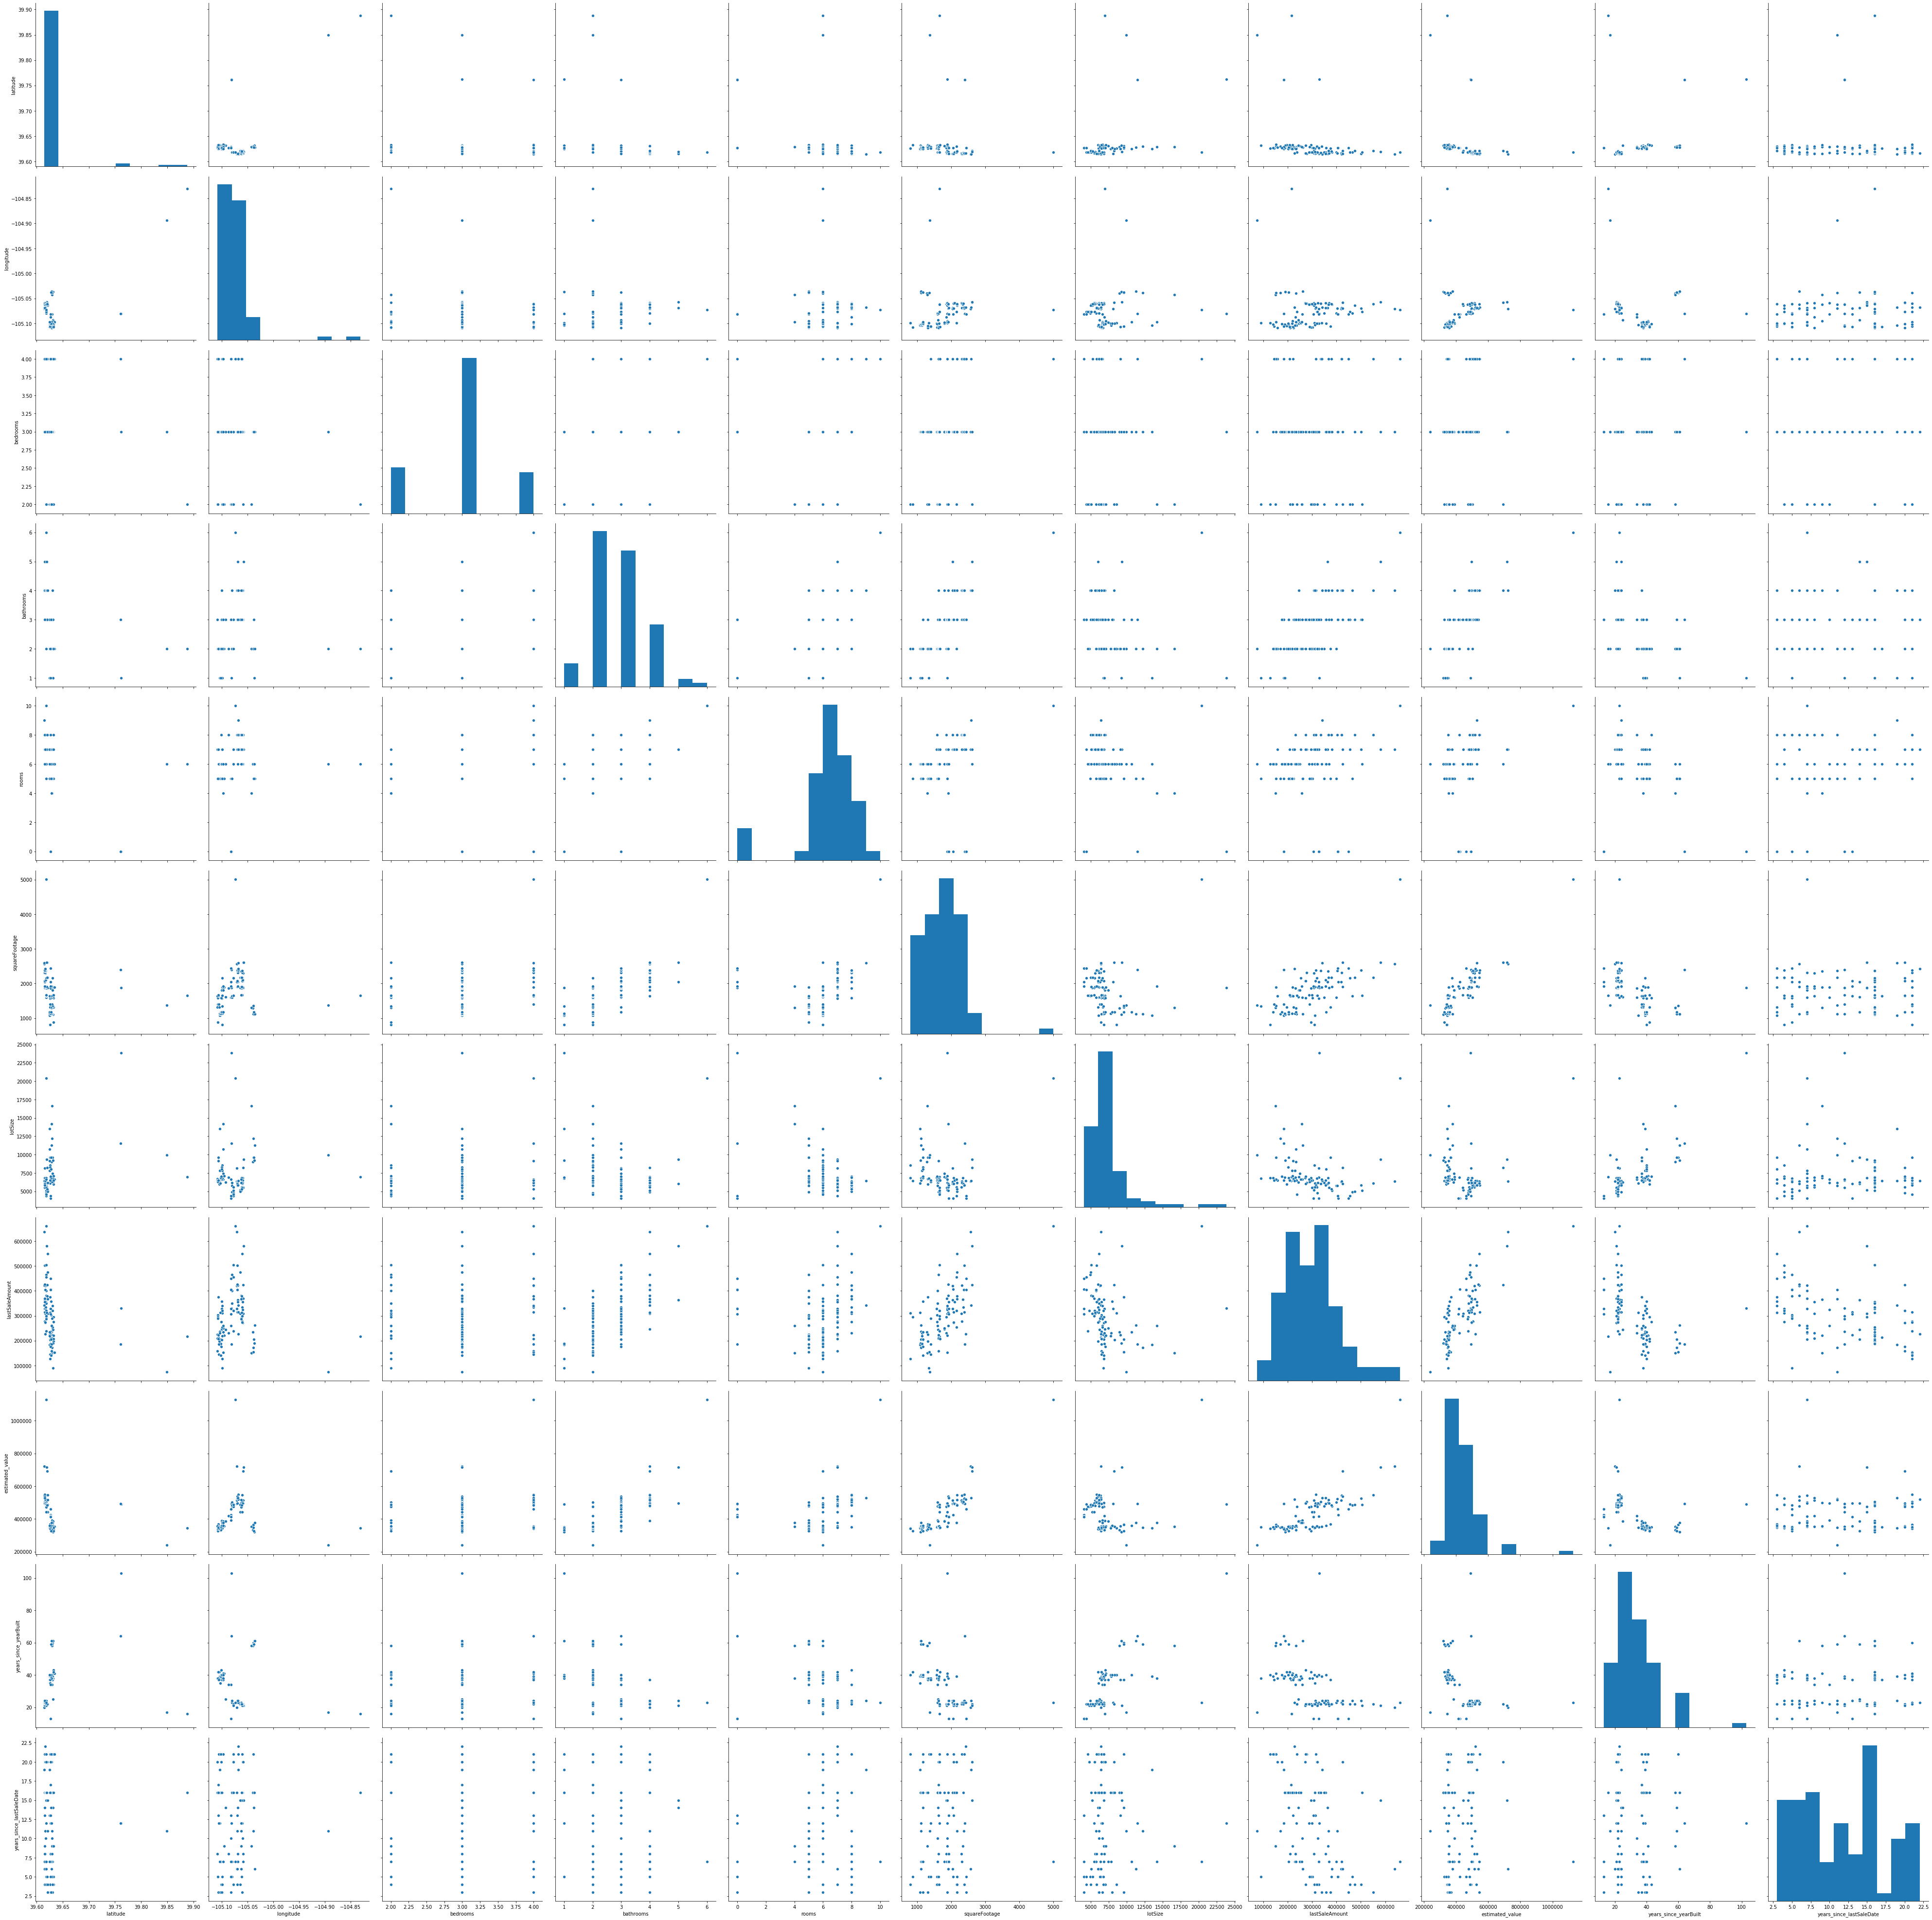

In [16]:
# sns.set(font_scale = 2) 
pp=sns.pairplot(df1.iloc[:100,:11], height=3,size=5)
pp.fig.draw(pp.fig.canvas.get_renderer())


From the pairplot above, we may have to squint, but we can see some outliers.  Let's investigate.

In [17]:
# These amounts don't look correct.  Its hard to imagine prices under 40,000 as realistic for a
# house in Denver, so I am going to drop these (140) rows. 
df1['lastSaleAmount'].loc[df['lastSaleAmount']<20000].count()


41

In [18]:
df1=df1.loc[df['lastSaleAmount']>20000]
df1.shape

(13401, 21)

In [19]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,13401.0,39.740570,0.023527,39.614531,39.727676,39.748049,39.758246,3.988802e+01
longitude,13401.0,-104.964054,0.039718,-105.108440,-104.978434,-104.957696,-104.937539,-1.048309e+02
bedrooms,13401.0,2.709052,0.896202,0.000000,2.000000,3.000000,3.000000,1.500000e+01
bathrooms,13401.0,2.197485,1.163904,0.000000,1.000000,2.000000,3.000000,1.200000e+01
rooms,13401.0,6.166107,1.959901,0.000000,5.000000,6.000000,7.000000,3.900000e+01
squareFootage,13401.0,1514.379151,829.442499,350.000000,987.000000,1270.000000,1761.000000,1.090700e+04
lotSize,13401.0,5824.141183,3071.674576,278.000000,4620.000000,5950.000000,6270.000000,1.228390e+05
lastSaleAmount,13401.0,407250.502127,809579.095218,20100.000000,195000.000000,320000.000000,462850.000000,4.560000e+07
estimated_value,13401.0,637806.389896,504520.064262,147767.000000,398954.000000,518635.000000,688797.000000,1.014531e+07
years_since_yearBuilt,13401.0,90.637863,29.858929,4.000000,71.000000,95.000000,113.000000,1.460000e+02


 In this table, we can see the extremes for each column, among other data.  This is a good place to look for anything out of place.  For instance, if we look at "priorSaleAmount", it has a minimum of 0, which is most likely incorrect, and if not, probably a special case that will not be useful in our model.  We can also see a very small "lastSaleAmount" of 259, which again, we should investigate, and most likely, disregard.

There are some listings with 0 Bathrooms, I hope that is not true, but let's look at these records.

In [20]:
pd.set_option('display.max_columns', 50)
df1.loc[(df['bathrooms']==0) | (df['rooms']==0 )| (df['bedrooms']==0)]

,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,lastSaleAmount,estimated_value,years_since_yearBuilt,years_since_lastSaleDate,zip__80022.0,zip__80033.0,zip__80123.0,zip__80203.0,zip__80204.0,zip__80205.0,zip__80206.0,zip__80207.0,zip__80209.0,zip__nan
2,39.761710,-105.081070,3,1.0,0,1882,23875,330000,488840,103,12,0,1,0,0,0,0,0,0,0,0
3,39.760780,-105.081060,4,3.0,0,2400,11500,185000,494073,64,12,0,1,0,0,0,0,0,0,0,0
9,39.626770,-105.081990,3,3.0,0,2054,4050,407000,424514,13,5,0,0,1,0,0,0,0,0,0,0
98,39.626900,-105.081990,3,3.0,0,1925,4050,328000,417243,13,7,0,0,1,0,0,0,0,0,0,0
100,39.626650,-105.081990,3,3.0,0,1925,4050,306249,414342,13,13,0,0,1,0,0,0,0,0,0,0
101,39.626390,-105.082000,4,3.0,0,2445,4050,450000,461230,13,3,0,0,1,0,0,0,0,0,0,0
102,39.627030,-105.081990,3,3.0,0,2445,4410,405000,461609,13,5,0,0,1,0,0,0,0,0,0,0
143,39.626520,-105.082000,4,3.0,0,2236,4050,417500,453661,13,4,0,0,1,0,0,0,0,0,0,0
1396,39.728603,-105.030410,0,1.0,4,595,6260,64900,262310,69,13,0,0,0,0,1,0,0,0,0,0
1538,39.726646,-105.037598,0,1.0,2,350,5960,100000,241357,96,3,0,0,0,0,1,0,0,0,0,0


Looking at these properties, they seem to have most other data, so we will keep them and impute their values.

In [21]:
# I can see from the heatmap above that these three features are most highly correlated with 
# square footage, so I'll base the imputation on those
df1.sort_values('squareFootage',inplace=True)
df1['bathrooms'].replace(to_replace=0.0, method='ffill',inplace=True)
df1['bedrooms'].replace(to_replace=0.0, method='ffill',inplace=True)
df1['rooms'].replace(to_replace=0.0, method='ffill',inplace=True)


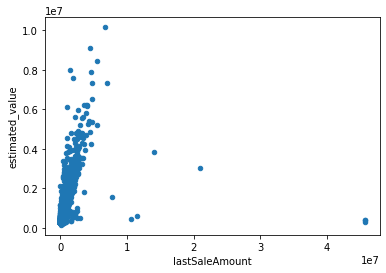

In [22]:
data = pd.concat([df1['lastSaleAmount'], df1['estimated_value']], axis=1)
data.plot.scatter(x='lastSaleAmount', y='estimated_value')


In [23]:
# Looking at houses last sold over 10M
df1.loc[df['lastSaleAmount']>1e7]

,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,lastSaleAmount,estimated_value,years_since_yearBuilt,years_since_lastSaleDate,zip__80022.0,zip__80033.0,zip__80123.0,zip__80203.0,zip__80204.0,zip__80205.0,zip__80206.0,zip__80207.0,zip__80209.0,zip__nan
2473,39.737062,-105.037810,2,1.0,4,700,6250,45600000,306400,67,13,0,0,0,0,1,0,0,0,0,0
2220,39.737493,-105.037811,2,1.0,6,929,4690,45600000,402561,106,13,0,0,0,0,1,0,0,0,0,0
2971,39.737183,-105.037810,2,1.0,5,1262,4690,45600000,397880,113,13,0,0,0,0,1,0,0,0,0,0
6419,39.763398,-104.955721,3,2.0,5,1515,6640,10625300,443985,68,3,0,0,0,0,0,1,0,0,0,0
202,39.742182,-104.980183,3,3.0,9,1548,6312,11500000,621536,135,5,0,0,0,1,0,0,0,0,0,0
13783,39.713170,-104.954070,2,6.0,6,3880,10125,14000000,3831949,5,7,0,0,0,0,0,0,0,0,1,0
13831,39.699982,-104.947079,6,5.0,13,4651,49900,21000000,3030815,62,9,0,0,0,0,0,0,0,0,1,0


45M for a 2 bedroom doesn't sound sane.  Especially given the age and time since last sale, and estimated value.  

- It looks more like a typo, so I could knock a couple of zeros off of these.  But it is unlikely that the price would have gone down after 13 years, so I will drop these 2.
- The third record is more likely prefixed by a erroneous 10.
- The fourth record appears to have an extra 0 at the end.
- The fifth record looks (14M for a 2 bedroom) looks like it's off by a factor of 10 and the room ratio looks off (6 rooms, 6 bathrooms, 2 beds), so I'll drop this record.

The last record looks like a genuine outlier, but still probably off by a factor of 10 given the estimate.  This one I will keep and change the lastSale Amount.


In [24]:
df1.drop(index=[2220,2971,13783, 202,6419], inplace=True)
# adjusting amount for the big house
df1.at[13831,'lastSaleAmount']=2100000

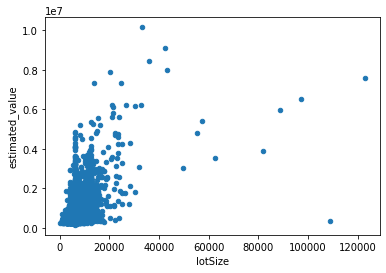

In [25]:
data = pd.concat([df1['estimated_value'], df1['lotSize']], axis=1)
data.plot.scatter(x='lotSize', y='estimated_value')

In [26]:
df1.loc[df['lotSize']>50000]

,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,lastSaleAmount,estimated_value,years_since_yearBuilt,years_since_lastSaleDate,zip__80022.0,zip__80033.0,zip__80123.0,zip__80203.0,zip__80204.0,zip__80205.0,zip__80206.0,zip__80207.0,zip__80209.0,zip__nan
6044,39.748706,-104.940803,4,1.5,6,2256,108900,340000,349664,75,20,0,0,0,0,0,1,0,0,0,0
14008,39.711010,-104.956434,4,7.0,10,4920,62510,3500000,3508978,22,12,0,0,0,0,0,0,0,0,1,0
14046,39.705675,-104.958624,4,7.0,12,4923,81893,1500000,3885943,49,21,0,0,0,0,0,0,0,0,1,0
13442,39.704374,-104.958606,6,8.0,13,7187,97125,4800000,6538208,18,6,0,0,0,0,0,0,0,0,1,0
13655,39.706183,-104.957094,5,6.0,14,7200,122839,2000000,7582992,19,21,0,0,0,0,0,0,0,0,1,0
13913,39.704232,-104.956407,3,6.0,13,8241,55300,3100000,4799277,7,7,0,0,0,0,0,0,0,0,1,0
13607,39.704295,-104.955257,6,9.0,18,8477,88862,2700000,5943146,64,17,0,0,0,0,0,0,0,0,1,0
13330,39.704609,-104.951745,4,8.0,16,8715,57466,4290000,5407649,59,14,0,0,0,0,0,0,0,0,1,0


 The 1 points on the right indicates a large lot size with a relatively low price.  Perhaps this could be farmland?  Whatever the reason, it does not seem to fit the pattern the other data is showing, so I'll delete this point.

In [27]:
df1=df1.drop(index=6044)

In order to isolate other outliers more efficiently, I'll use an isolation Forest which is adept at identifying anomalies.

In [28]:
# clf = IsolationForest(max_samples=100, random_state=99)
# clf.fit(df1)
# y_no_ol = clf.predict(df1)
# y_no_ol = pd.DataFrame(y_no_ol, columns=['top'])
# y_no_ol[y_no_ol['top'] == 1].index.values

# df3 = df1.iloc[y_no_ol[y_no_ol['top'] == 1].index.values]
# df3.reset_index(drop = True, inplace = True)
# print("Number of Outliers:", y_no_ol[y_no_ol['top'] == -1].shape[0])
# print("Number of rows without outliers:", df3.shape[0])
# df3

## Testing Assumptions of Distribution

In [29]:
# Now lets check our target variable distribution
def checkNormal(data, feature):
    """
    Checks for gaussian distribution of a feature. Prints skewness 
    and kurtosis.
    
    """

    sns.distplot(df1[feature])
    fig=plt.figure()
    res = stats.probplot(df1[feature], plot=plt)
    print(f"{feature} Skewness : {df1[feature].skew()}")
    print(f"{feature} Kurtosis : {df1[feature].kurt()}")

The skewness is not ideal and does not follow the line.  We may need to transform the target variable to get a better fit.  This is pushing our assumption of normality, so let's get this variable closer to normal.

In [30]:
# This will take the log of the estimated price to 
# normalize the distribution
def transformFeature(df, feature, lam=0):
    """
    Transforms the feature to achieve a more normal distribution.  
    
    This can allow the models to perform better.
    
    feature = string, columns name
    lam = int [-1,-0.5,0,0.5, 1]
        -1 = reciprocal
        -0.5 = reciprocal square root
        0 = log
        0.5 = square root
        1 = None
    """
    # This will take the log (lambda = 0) of the estimated price to 
    # normalize the distribution
    data=stats.boxcox(df[feature], lmbda=lam)
    sns.distplot(data)
    fig=plt.figure()
    res_1=stats.probplot(data, plot=plt)
    df[feature] = data
    return df[feature]

It only makes sense to apply this to the previous sales prices as well.

estimated_value Skewness : 5.946640784554276
estimated_value Kurtosis : 58.144194426088134


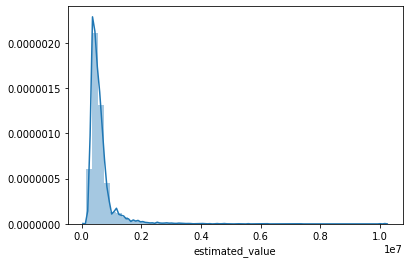

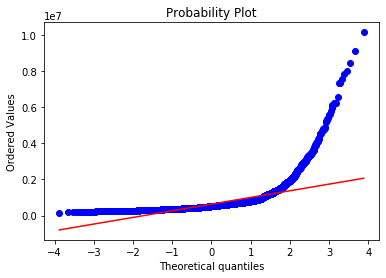

In [31]:
checkNormal(df1,'estimated_value')

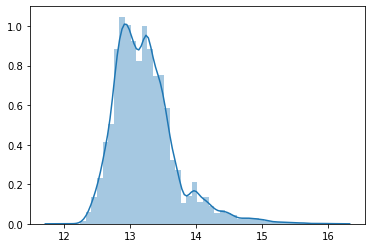

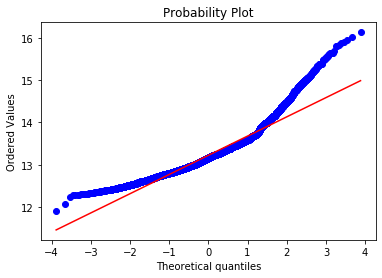

In [32]:
df1['estimated_value']=transformFeature(df1, 'estimated_value', 0)


lastSaleAmount Skewness : 46.31781163207294
lastSaleAmount Kurtosis : 3759.911990217221


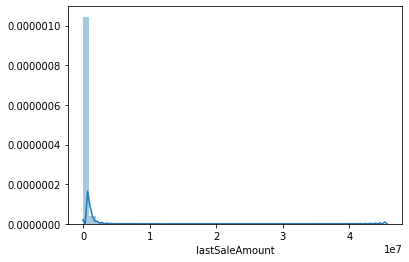

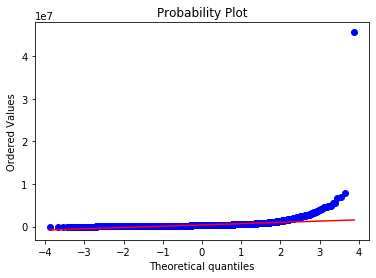

In [33]:
checkNormal(df1, 'lastSaleAmount')

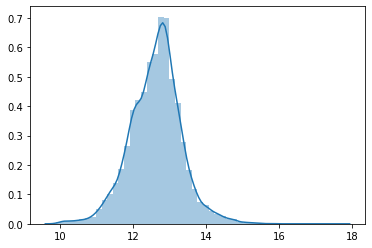

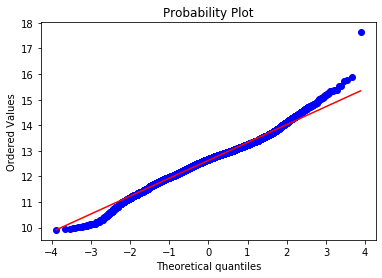

In [34]:
df1['lastSaleAmount']=transformFeature(df1, 'lastSaleAmount', 0)

latitude Skewness : -1.6707572343576085
latitude Kurtosis : 5.652641235396089
longitude Skewness : -0.9316720475997856
longitude Kurtosis : 0.4691612579687776
bedrooms Skewness : 1.490924391217267
bedrooms Kurtosis : 7.2213433389074915
bathrooms Skewness : 1.5931528542605855
bathrooms Kurtosis : 4.2321419573238135
rooms Skewness : 2.2666629656128627
rooms Kurtosis : 14.163007428517389
squareFootage Skewness : 2.4945059618796
squareFootage Kurtosis : 10.26767964781915
lotSize Skewness : 13.13960694814175
lotSize Kurtosis : 374.7282382811029
lastSaleAmount Skewness : -0.03343153928144901
lastSaleAmount Kurtosis : 1.1898056204265335
estimated_value Skewness : 1.3254790968411174
estimated_value Kurtosis : 3.0459949816354954
years_since_yearBuilt Skewness : -0.7259185716530795
years_since_yearBuilt Kurtosis : 0.4055652860831169
years_since_lastSaleDate Skewness : 0.5897262207204527
years_since_lastSaleDate Kurtosis : -0.7737859729882133
zip__80022.0 Skewness : 81.82908881329152
zip__80022.0

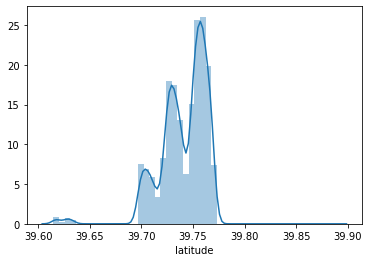

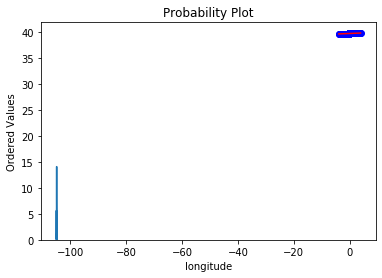

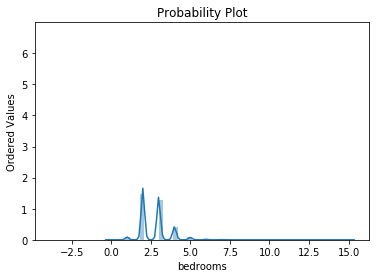

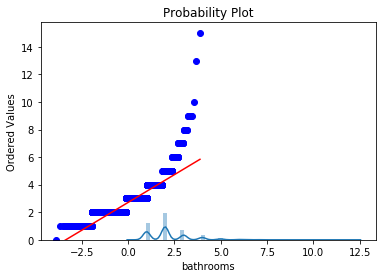

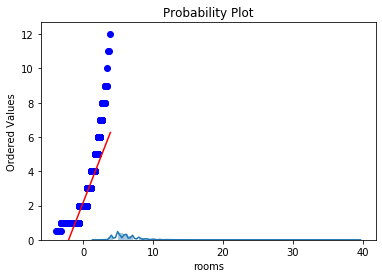

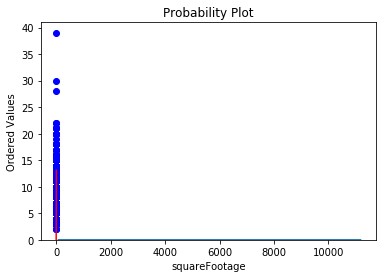

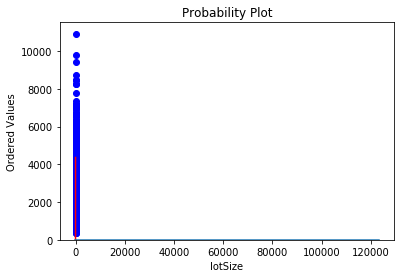

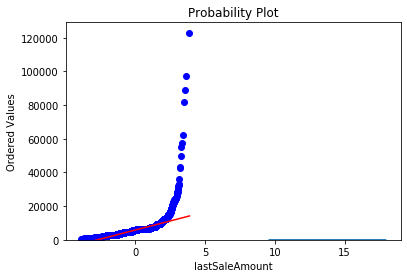

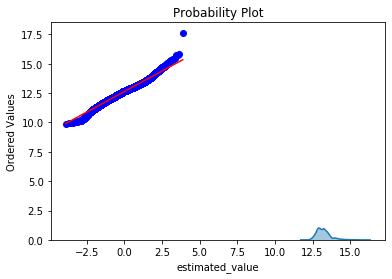

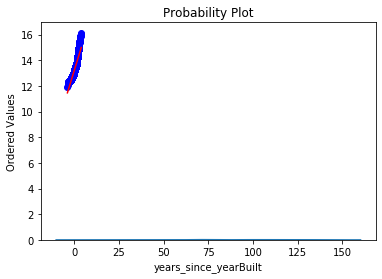

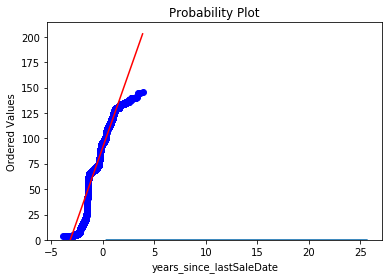

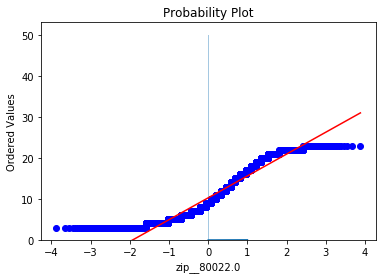

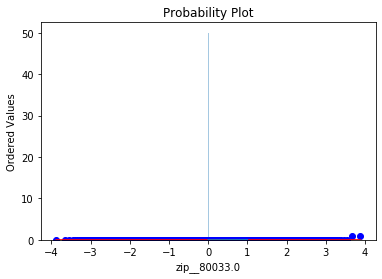

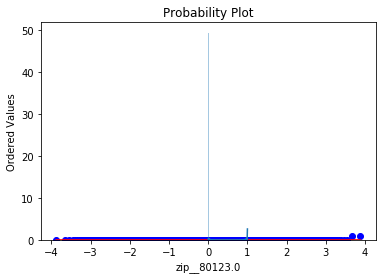

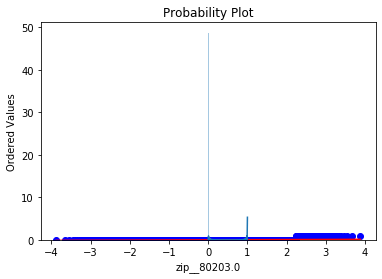

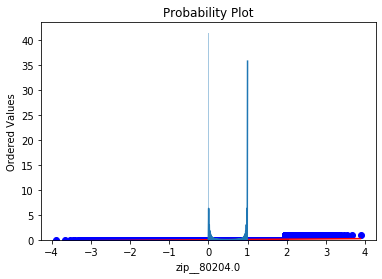

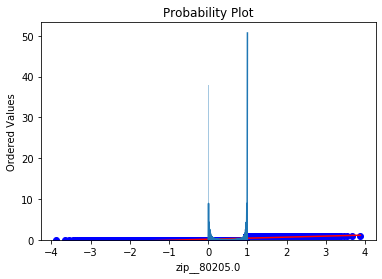

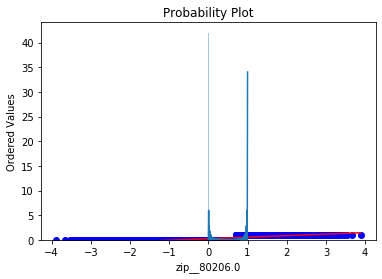

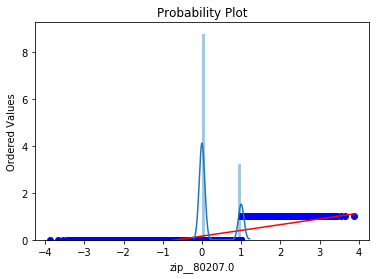

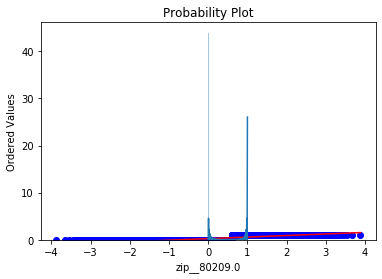

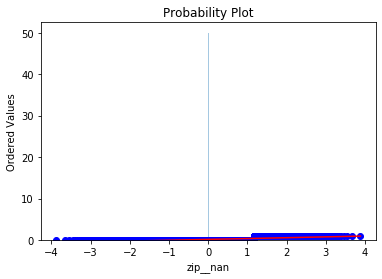

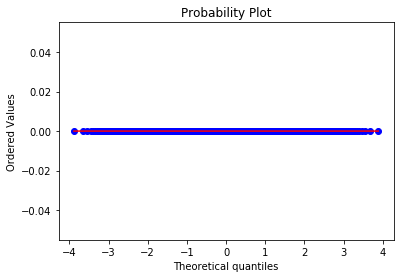

In [35]:
for i in df1.columns:
    checkNormal(df1,i)

squareFootage Skewness : 2.4945059618796
squareFootage Kurtosis : 10.26767964781915


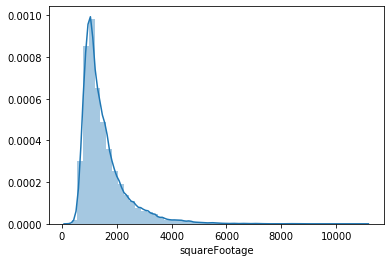

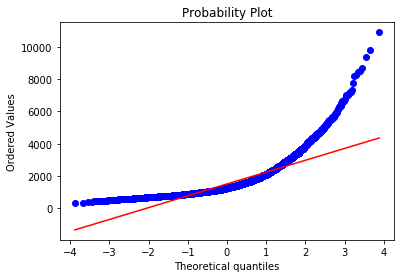

In [36]:
checkNormal(df1, 'squareFootage')

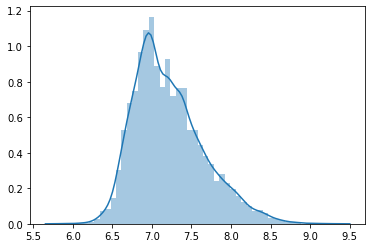

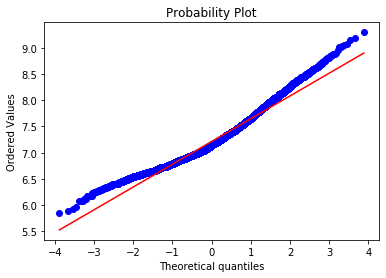

In [37]:
df1['squareFootage']=transformFeature(df1, 'squareFootage',0)

lotSize Skewness : 13.13960694814175
lotSize Kurtosis : 374.7282382811029


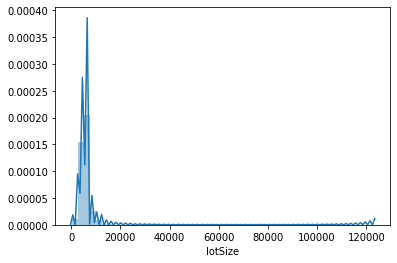

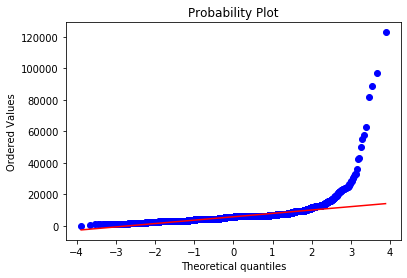

In [38]:
checkNormal(df1, 'lotSize')

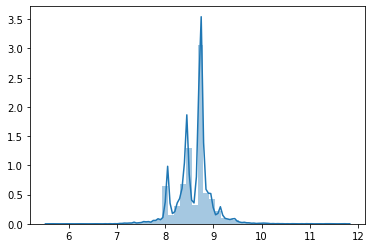

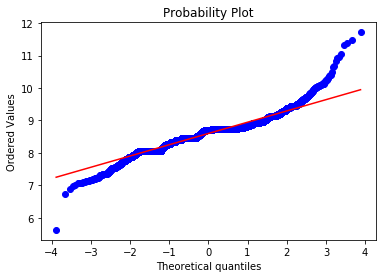

In [39]:
df1['lotSize']=transformFeature(df1, 'lotSize',0)

# Transforming the Test Data
We will need to transform the test data as well.  

In [41]:
X=df1.drop(columns='estimated_value')
y=df1['estimated_value']

In [42]:
# Transform test data

def transformTest(df_test, df_train=X):
    """
    This loads the test dataset, and transforms it for this model
    
    input = dataframe of validation data
    """
    df=df_test
    
    # Impute null Year Built Data
    df['yearBuilt'].fillna(df['yearBuilt'].median(), inplace=True)
    # Convert to Datetime
    df['yearBuilt']=pd.to_datetime(df['yearBuilt'], format='%Y')
    convertDatetime(df, columns=['yearBuilt','lastSaleDate'])
    
    # Drop unnecessary columns
    df.drop(columns=['id','address','city','state',
            'priorSaleAmount','priorSaleDate', 
            'yearBuilt','lastSaleDate'], 
            inplace=True)
    
    # One Hot encode zips
    df = oneHot(df)
    df_train, df = df_train.align(df,join='left', fill_value=0, axis=1)
    col_df = df.columns
    
    # imputing null values using knn
    df=pd.DataFrame(KNN(k=5).fit_transform(df))
    df.columns=col_df
    
    df['lastSaleAmount']=transformFeature(df, 'lastSaleAmount', 0)
    df['squareFootage']=transformFeature(df, 'squareFootage', 0)
    df['lotSize']=transformFeature(df, 'lotSize', 0)
    return df

# Modeling
 

## Linear Regression
I'm going to start with a regression model as a baseline.

Imputing row 1/1539 with 0 missing, elapsed time: 0.558
Imputing row 101/1539 with 0 missing, elapsed time: 0.560
Imputing row 201/1539 with 0 missing, elapsed time: 0.561
Imputing row 301/1539 with 0 missing, elapsed time: 0.562
Imputing row 401/1539 with 0 missing, elapsed time: 0.562
Imputing row 501/1539 with 0 missing, elapsed time: 0.563
Imputing row 601/1539 with 0 missing, elapsed time: 0.564
Imputing row 701/1539 with 0 missing, elapsed time: 0.564
Imputing row 801/1539 with 0 missing, elapsed time: 0.566
Imputing row 901/1539 with 0 missing, elapsed time: 0.568
Imputing row 1001/1539 with 0 missing, elapsed time: 0.569
Imputing row 1101/1539 with 0 missing, elapsed time: 0.569
Imputing row 1201/1539 with 0 missing, elapsed time: 0.570
Imputing row 1301/1539 with 0 missing, elapsed time: 0.570
Imputing row 1401/1539 with 0 missing, elapsed time: 0.571
Imputing row 1501/1539 with 0 missing, elapsed time: 0.572


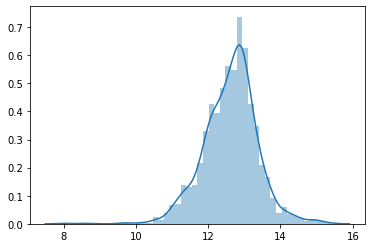

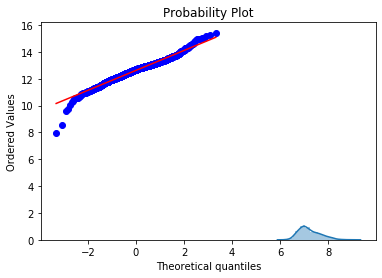

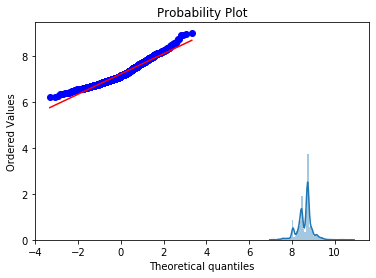

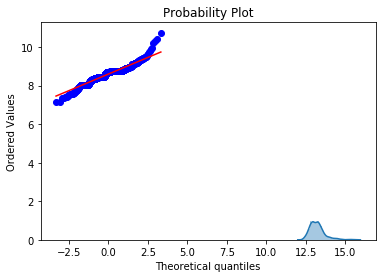

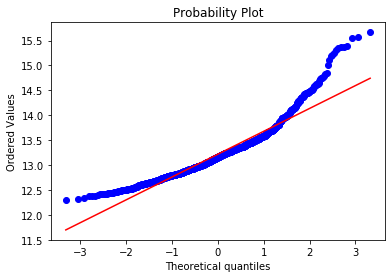

In [43]:

X_val=transformTest(test.drop(columns='estimated_value'))
y_val = transformFeature(test,'estimated_value')


In [44]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=99)
lr=LinearRegression()
lr.fit(X_train,y_train)
cv_score = cross_val_score(lr, X_train, y_train, cv=5).mean()

lr_score = lr.score(X_test, y_test)
preds = lr.predict(X_test)
lr_z_score = stats.zscore(preds).mean()
lr_val_score = lr.score(X_val, y_val)

print(f'cross val score: {cv_score}')
print(f'test_score : {lr_score}')
print(f'z_score : {lr_z_score}')
print(f'validation score: {lr_val_score}')

cross val score: 0.8882670142435952
test_score : 0.8894666348069383
z_score : -4.849576166806955e-15
validation score: 0.8669121123494078


## Principal Component Analysis
I'm going to use PCA to explore feature interactions.

In [45]:
# Here I am looking at feature interactions to the third degree
# ex: latitude * longitude * zipcode or lotSize**3
pf = PolynomialFeatures(degree=3)
X_pf = pf.fit_transform(X)
X_val_pf = pf.transform(X_val)

# Split and scale 
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, random_state=99)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)
X_val_sc = ss.transform(X_val_pf)

# Instantiating PCA model returning components explaining 99% of variance
pca = PCA(n_components=0.99)
pca.fit(X_train_sc)
Z_train = pca.transform(X_train_sc)
Z_test = pca.transform(X_test_sc)
Z_val = pca.transform(X_val_sc)

# Taking a look at the top 20 components 
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 25 components): {np.round(cum_var_exp[:25],3)}')

Cumulative explained variance (first 25 components): [0.158 0.263 0.354 0.438 0.517 0.596 0.673 0.747 0.808 0.863 0.896 0.911
 0.922 0.93  0.937 0.942 0.946 0.95  0.954 0.957 0.961 0.964 0.966 0.969
 0.972]


In [46]:
# Instantiating regression model
lm = LinearRegression()

# fit the model
lm.fit(Z_train, y_train)

# test val data
preds = lm.predict(Z_val)
lm_val_score = lm.score(Z_val, y_val)
print(f'Training Score: {round(lm.score(Z_train, y_train),4)}')
print(f'Testing Score: {round(lm.score(Z_test, y_test),4)}')
print(f'Validation Score: {round(lm_val_score, 4)}')

Training Score: 0.9053
Testing Score: 0.905
Validation Score: 0.8857


This model covers a good amount of variance, and is an improvement over our baseline, and is not overfit.

## Lasso
Lasso seems like a good choice because it is great at dropping unimportant features.

In [47]:
X_train_sc.shape

(10046, 1771)

In [48]:
lasso = LassoCV(n_alphas=200, cv=5)
lasso_scores = cross_val_score(lasso, X_train_sc, y_train, cv=5)

lasso.fit(X_train_sc, y_train)
ls_train_score = lasso.score(X_train_sc, y_train)
ls_test_score = lasso.score(X_test_sc, y_test)
ls_val_score = lasso.score(X_val_sc, y_val)
print(f'Lasso train score: {ls_train_score}')
print(f'Lasso test score: {ls_test_score}')
print(f'Lasso val score: {ls_val_score}')


Lasso train score: 0.9239392329032997
Lasso test score: 0.9246949135774194
Lasso val score: 0.908150187463229


In [49]:
# Extracting the features selected by Lasso for use in other models
feats = SelectFromModel(lasso, prefit=True)
select_feats = feats.get_support()
X_train_selected = feats.transform(X_train_sc)

I had a suspicion that Lasso would be a natural choice for this dataset.  Here we can see an improvement over our PCA scores.  

## Neural Network

In [50]:
# Selecting the features chosen by Lasso for NN
X_train_selected = feats.transform(X_train_sc)
X_test_selected = feats.transform(X_test_sc)
X_val_selected = feats.transform(X_val_sc)

In [51]:
keras.backend.clear_session()

In [52]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', 
                input_shape=(X_train_selected.shape[1],)),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = keras.optimizers.RMSprop(0.001)
    
    model.compile(loss = 'mean_squared_error',
                 optimizer='adam',
                 metrics=['mse'])
    return model

In [53]:
model = build_model();

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                8320      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 13,537
Trainable params: 13,537
Non-trainable params: 0
____________________________________________________

In [55]:
hist = model.fit(X_train_selected, y_train,
         epochs = 100,
          batch_size = 32,
#           validation_split=.20,
          validation_data = (X_test_selected, y_test),
          workers = 4,
          verbose = 1
         )

Train on 10046 samples, validate on 3349 samples
Epoch 1/100
10046/10046 [==============================] - 1s 147us/sample - loss: 30.5810 - mse: 30.5810 - val_loss: 8.4822 - val_mse: 8.4822
Epoch 2/100
10046/10046 [==============================] - 1s 70us/sample - loss: 9.9035 - mse: 9.9035 - val_loss: 8.5012 - val_mse: 8.5012
Epoch 3/100
10046/10046 [==============================] - 1s 88us/sample - loss: 7.6771 - mse: 7.6771 - val_loss: 10.8477 - val_mse: 10.8477
Epoch 4/100
10046/10046 [==============================] - 1s 81us/sample - loss: 6.2616 - mse: 6.2616 - val_loss: 9.4670 - val_mse: 9.4670
Epoch 5/100
10046/10046 [==============================] - 1s 77us/sample - loss: 5.2495 - mse: 5.2495 - val_loss: 9.3328 - val_mse: 9.3328
Epoch 6/100
10046/10046 [==============================] - 1s 76us/sample - loss: 4.6695 - mse: 4.6695 - val_loss: 7.5315 - val_mse: 7.5315
Epoch 7/100
10046/10046 [==============================] - 1s 75us/sample - loss: 3.6634 - mse: 3.6634 - v

10046/10046 [==============================] - 1s 81us/sample - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 59/100
10046/10046 [==============================] - 1s 82us/sample - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0414 - val_mse: 0.0414
Epoch 60/100
10046/10046 [==============================] - 1s 76us/sample - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 61/100
10046/10046 [==============================] - 1s 73us/sample - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0364 - val_mse: 0.0364
Epoch 62/100
10046/10046 [==============================] - 1s 69us/sample - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 63/100
10046/10046 [==============================] - 1s 70us/sample - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0373 - val_mse: 0.0373
Epoch 64/100
10046/10046 [==============================] - 1s 74us/sample - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 65/100
10046/10046 [

Neural Network Validation r2 score: 0.8718390469550393


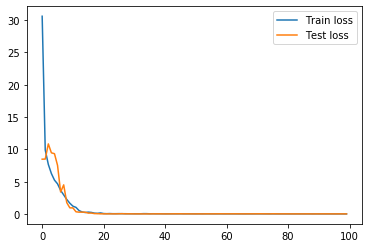

In [56]:
pred = model.predict(X_val_selected)
nn_val_score = metrics.r2_score(y_val, pred)

print(f'Neural Network Validation r2 score: {nn_val_score}')

plt.plot(hist.history['loss'], label = 'Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend();

## Conclusion

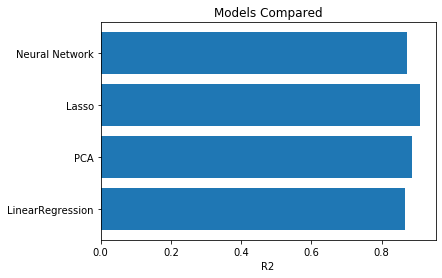

In [57]:
scores=[lr_val_score,lm_val_score, ls_val_score, nn_val_score]
models=['LinearRegression','PCA','Lasso','Neural Network']

yp = np.arange(len(models))

plt.barh(y=yp, width=scores, align='center')
plt.yticks(yp,models)
plt.xlabel('R2')
plt.title('Models Compared')

plt.show()

## Final Model

In [58]:
def predict_house_price(dataframe, train_df=df1):
    """
    Takes test dataframe of Denver houses as input.
    
    Saves output of predicted prices as .csv
    """
    # transform features
    df_test = transformTest(dataframe)

    # Creating polynomial features
    pf = PolynomialFeatures(degree=3)
    X_pf = pf.fit_transform(df_test)
    
    # Scale features
    ss=StandardScaler()
    X_sc = ss.fit_transform(X_pf)
    
    # Predict Prices
    preds = lasso.predict(X_sc)
    
    # Unscale prediction
    output = inv_boxcox(preds,0)
    

    return output

# Enter Test Dataset Here
Enter the path to the test csv below.  Then run the following 2 cells.  The predicted house prices will be saved to a variable called 'prices' and the last cell will save the predictions to a csv file in the current working directory.  

In [ ]:
test_set = pd.read_csv(PATH_TO_TEST_SET)

prices = predict_house_price(test_set)

In [ ]:
# Save csv of prices
np.savetxt('price_predictions.csv', output, delimiter=',') 